In [2]:
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math
import EoN
import seaborn as sns
import time
from scipy.stats import expon

# New Imports
#from ctrace.contact_tracing import *
#from ctrace.constraint import *
#from ctrace.solve import *
#from ctrace.simulation import *
#from ctrace.restricted import *
from ctrace.simulation import *
from ctrace.dataset import *
from ctrace.utils import *
from ctrace.recommender import *
from ctrace.problem import *

In [2]:
G = load_graph("montgomery")

In [3]:
SIR_Tuple = namedtuple("SIR_Tuple", ["S", "I", "R"])
SIRQ_Tuple = namedtuple("SIR_Tuple", ["S", "I", "R", "Q"])

In [4]:
I = set()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "t7.json", 'r') as infile:
    j = json.load(infile)
    (S, infected_queue, R) = (j["S"], j["I_Queue"], j["R"])

    # Make infected_queue a list of sets
    infected_queue = [set(s) for s in infected_queue]
    I = I.union(*infected_queue)
    I = list(I)

In [3]:
S = []
I = []
R = []

for i in range(len(G.nodes)):
    if random.random() > .0003:
        S.append(i)
    else:
        I.append(i)
        
state = SimulationState(G, (S,I,R), (S,I,R), 500, .078,1,1, 1,1)
t = 0

#while len(state.SIR_real.SIR[1]) != 0:
while t != 3:
    #to_quarantine = agent(state)
    print(t, len(state.SIR_real.SIR[0]), len(state.SIR_real.SIR[1]), len(state.SIR_real.SIR[2]))
    state.step([])
    t+=1
    
print(t, len(state.SIR_real.SIR[0]), len(state.SIR_real.SIR[1]), len(state.SIR_real.SIR[2]))


NameError: name 'G' is not defined

In [63]:
len(state.SIR_real.V2)

16353

2741

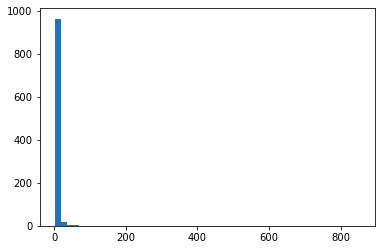

In [12]:
from scipy.stats import zipf

deg = [zipf.rvs(a=2)+1 for _ in range(1000)]

plt.hist(deg,bins=50)

G = nx.expected_degree_graph(deg)
len(G.edges)

In [258]:
nx.write_adjlist(G, "../data/graphs/power")

In [227]:
G = nx.read_adjlist("../data/graphs/power")

In [13]:
S = []
I = []
R = []

for i in range(len(G.nodes)):
    if random.random() > .15:
        S.append(i)
    else:
        I.append(i)
        
SIR = SIR_Tuple(S,I,R)

In [27]:
state = InfectionInfo(G,SIR,100,.5)
print(len(state.SIR.I))
print(len(state.V1))
print(len(state.V2))


142
229
511


In [29]:
robust_experiment(G, SIR, .5, .8, 100, "greedy", num_samples=1, num_objectives=1000)

hi


(105.179, 213.0, 297.0)

In [16]:
def robust_experiment(
    G,
    SIR,
    transmission_rate,
    compliance_rate,
    budget,  # number of nodes to quarantine in V1
    method,  # robust | greedy
    num_objectives=10,
    # Number of samples for SAA (Increasing samples -> more accuracy?)
    num_samples=1,
    **args,
):
    

    info = InfectionInfo(G, SIR, budget, transmission_rate)
    if method == "robust":
        action = SAAAgent(
            info=info,
            debug=False,
            num_samples=num_samples,
            transmission_rate=transmission_rate,
            compliance_rate=compliance_rate,
            structure_rate=0,
            solver_id="GLOP"
        )
        # Running the objective multiple times?
        
    elif method == "greedy":
        # Generate Greedy action
        info = InfectionInfo(G, SIR, budget, transmission_rate)
        # actions -> set of node ids
        action = DegGreedy(info)
    elif method == "none":
        objs = [grader(G, SIR, budget, transmission_rate,
                    compliance_rate, set()) for _ in range(num_objectives)]
    else:
        raise ValueError(f"Invalid method ({method}): must be one the values")
    print("hi")
    objs = [grader(G, SIR, budget, transmission_rate,
                    compliance_rate, action) for _ in range(num_objectives)]
    
    with open(PROJECT_ROOT / "output" / "robust.json", 'r+') as infile:
        data = json.load(infile)
        
        data[method + str(num_samples)] = objs
        infile.seek(0)
        json.dump(data,infile)
        infile.truncate()
        
    return (mean(objs),np.percentile(objs, 95), max(objs))

In [182]:
with open(PROJECT_ROOT / "output" / "robust1.json", 'r+') as infile:
    data = json.load(infile)
    
    for i in range(100,4001,100):
        name = "robust" + str(i)
        if name in data:
            data[name].sort()
            print(i, mean(data[name]), mean(data[name][-1000:]), np.percentile(data[name], 95), max(data[name]))
            #print(len(data[name]))
    name = "greedy1"
    if name in data:
        data[name].sort()
        print(name, mean(data[name]), np.std(data[name]), mean(data[name][-10:]), max(data[name]))
    

100 280.9785 415.764 406.0 439.0
200 280.2769259259259 416.309 406.0 437.0
300 280.639619047619 414.671 406.0 435.0
400 279.4676666666667 416.015 406.0 433.0
500 280.1981666666667 416.899 406.0 435.0
600 280.57985185185186 416.214 406.0 434.0
700 280.58843333333334 417.54 407.0 436.0
800 279.7114074074074 415.708 406.0 437.0
900 280.1067619047619 414.303 406.0 435.0
1000 279.8052962962963 415.879 406.0 435.0
1100 281.09090476190477 414.204 406.0 433.0
1200 280.3586666666667 391.064 406.0 433.0


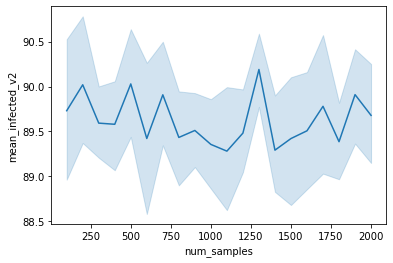

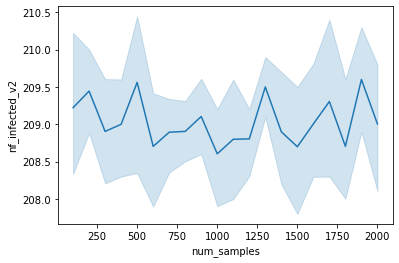

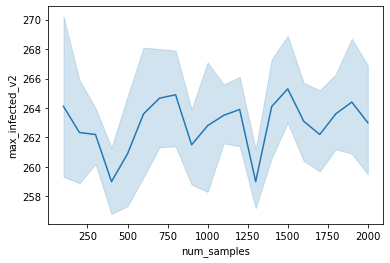

(196, 13)


In [112]:
df = pd.read_csv("../output/run_8wV36/results.csv")
df = df[df.mean_infected_v2 != 'None']
df['mean_infected_v2'] = df['mean_infected_v2'].astype(float)
df['nf_infected_v2'] = df['nf_infected_v2'].astype(float)
df['max_infected_v2'] = df['max_infected_v2'].astype(float)

sns.lineplot(data=df,x='num_samples',y='mean_infected_v2')
plt.show()
sns.lineplot(data=df,x='num_samples',y='nf_infected_v2')
plt.show()
sns.lineplot(data=df,x='num_samples',y='max_infected_v2')
plt.show()


print(df.shape)

In [108]:
df['mean_infected_v2'].unique()

array(['90.0578', '91.1926', '88.5642', '88.7468', '88.9922', '91.5998',
       '89.9162', '90.4574', '88.053', '89.8666', '91.5624', '92.0334',
       '89.6834', '89.6084', '90.5984', '89.5912', '89.7932', '89.8738',
       '88.711', '88.4854', '88.4412', '89.768', '88.4922', '89.4316',
       '89.7796', '91.0386', '90.2654', '89.4642', '89.1826', '88.8736',
       '89.9354', '90.6652', '88.9492', '90.4362', '89.3782', '89.6286',
       '90.4738', '88.2676', '89.3194', '89.7544', '90.8446', '88.8186',
       '89.57', '90.7088', '88.991', '90.5032', '91.3014', '90.2884',
       '89.2884', '86.4984', '90.591', '88.783', '88.3256', '91.1936',
       '91.2554', '90.2576', '89.2428', '88.847', '91.3248', '90.8348',
       '89.0728', '89.4662', '88.1802', '90.2796', '90.0154', '89.702',
       '89.2034', '88.2206', '90.2536', '89.1022', '90.7852', '89.2146',
       '90.3692', '89.0286', '88.4654', '88.7764', '89.2354', '88.4638',
       '89.954', '90.014', '90.7688', '89.3864', '88.4574', '

In [63]:
state = SimulationState(G, (S,I,R), (S,I,R), 1000, .078,.1,1,1,1)
info = state.SIR_known

P, Q = pq_independent(info.G, info.SIR.I, info.V1, info.transmission_rate)
    
weights: List[Tuple[int, int]] = []
for u in info.V1:
    w_sum = sum([Q[u][v] for v in info.G.neighbors(u) if v in info.V2]) # V2 is a set!
    weights.append((P[u] * w_sum, u))

a = [i[0] for i in weights]

In [64]:
1/mean(a)

16.50973393436457

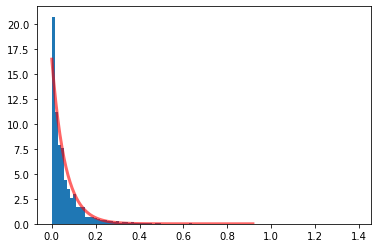

In [67]:
plt.hist(a,bins=100,density=True)
x = np.linspace(expon.ppf(0.00), expon.ppf(0.6), 100)
plt.plot(x, expon.pdf(x,scale=mean(a)),'r-', lw=3, alpha=0.6, label='expon pdf')
plt.show()


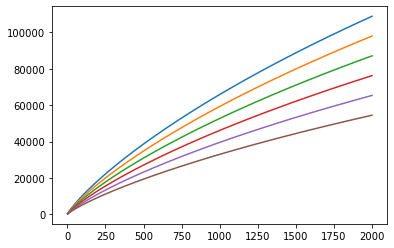

In [73]:
n=20000
b = 1/mean(a)
x=[i for i in range(2,2000)]
y = [(-b*math.lgamma(i+1) + b*i*math.log(n+1)) for i in x]
y1 = [.9*(-b*math.lgamma(i+1) + b*i*math.log(n+1)) for i in x]
y2 = [.8*(-b*math.lgamma(i+1) + b*i*math.log(n+1)) for i in x]
y3 = [.7*(-b*math.lgamma(i+1) + b*i*math.log(n+1)) for i in x]
y4 = [.6*(-b*math.lgamma(i+1) + b*i*math.log(n+1)) for i in x]
y5 = [.5*(-b*math.lgamma(i+1) + b*i*math.log(n+1)) for i in x]

plt.plot(x,y)
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y4)
plt.plot(x,y5)


In [188]:
#this is how the code is used
for i in range(1):
    state = SimulationState(G, (S,I,R), (S,I,R), 1000, .078,.1,1,1,1)
    agent = DepRound

    while len(state.SIR_known.SIR[1]) != 0:
        #print(len(state.SIR_known.SIR[1]))
        to_quarantine = agent(state)
        state.step(to_quarantine)

        #print(state.SIR_known.V1 == state.SIR_real.V1)
        #print("S :" + str(len(state.SIR_known.SIR.S)) + " " + str(len(state.SIR_real.SIR.S)))
        #print("I :" + str(len(state.SIR_known.SIR.I)) + " " + str(len(state.SIR_real.SIR.I)))
        #print("R :" + str(len(state.SIR_known.SIR.R)) + " " + str(len(state.SIR_real.SIR.R)))

        #print()

        #print(len(set(state.SIR_known.SIR.R).difference(set(state.SIR_real.SIR.R))))
        #print(len(set(state.SIR_real.SIR.R).difference(set(state.SIR_known.SIR.R))))

    #print(len(state.SIR_known.SIR[1]))
    #print()
    print(len(state.SIR_known.SIR[2])/75457)
    #print(len(state.SIR_known.SIR[0]),len(state.SIR_real.SIR[0]))

0.4757544031700174


In [189]:
print(len(state.SIR_real.SIR[2])/75457)


0.4757676557509575


In [165]:
print(len(state.SIR_known.SIR[2]))
print(len(state.SIR_real.SIR[2]))

33434
33434


In [27]:
state.SIR_known.quarantined

([], [], [])

In [28]:
len(state.SIR_real.SIR[0] + state.SIR_real.SIR[1] + state.SIR_real.SIR[2])

75457

In [179]:
agents = [NoIntervention, Random, Degree, DepRound, DegGreedy]

In [180]:
for agent in agents:
    state = SimulationState(G, (S,I,R), (S,I,R), 2000, .078,1,1, 1,1)

    while len(state.SIR_known.SIR[1]) != 0:
        to_quarantine = agent(state)
        state.step(to_quarantine)

    print(agent.__name__ + " " + str(len(state.SIR_known.SIR[2])))


NoIntervention 36169
Random 30674
Degree 24299
DegGreedy 21525
DepRound 23785
